In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Sarcasm Detection/Tamil/sarcasm_tam_train (1).csv',usecols=['Text','labels'])
df.dropna()
df

,Text,labels
0,அர்யவுக்கு ஒரு நல்ல வாய்ப்பு சிங்கம் சூரியா அ...,Non-sarcastic
1,பள்ளியோ கல்லூரியோ படித்துக்கொண்டிருக்கும்போது ...,Non-sarcastic
2,தல தல தல தல தல தல தல தல தல தல தல தல தல தல தல த...,Non-sarcastic
3,All the best to the team....super ah na Oru ka...,Non-sarcastic
4,"Bahut over mack up kiya hua hai, it is look li...",Non-sarcastic
...,...,...
29565,Ajth sar mass vasanam Ner konda baarvai mass,Non-sarcastic
29566,Adei anga ENPT trailer mukkitu iruku innum,Sarcastic
29567,KV ANANDH SIR SENTIMENT ayan maatran kavan ma...,Non-sarcastic
29568,ஒவ்வொருத்தருக்கும் ஒவ்வொரு பைத்தியம். நமக்கு ய...,Non-sarcastic


labels
Non-sarcastic    21740
Sarcastic         7830
Name: count, dtype: int64


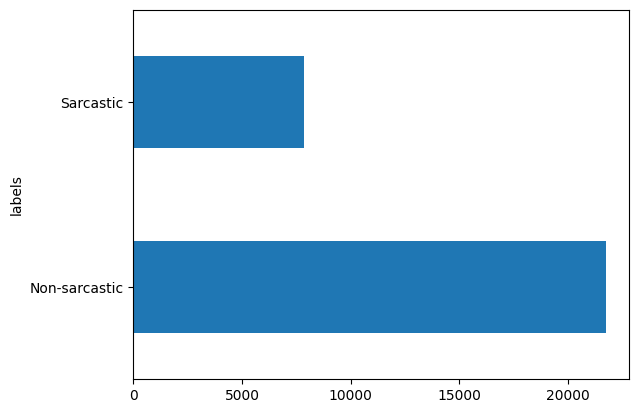

In [ ]:
df['labels'].value_counts().plot(kind='barh')
print(df['labels'].value_counts())

<Axes: ylabel='count'>

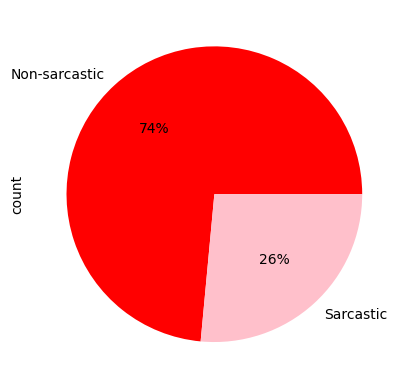

In [ ]:
df['labels'].value_counts().plot(kind='pie',y='labels',autopct='%1.0f%%',colors=["red", "pink"])

In [ ]:
df['labels']=df['labels'].replace({'Non-sarcastic':0,'Sarcastic':1})

In [ ]:
X=df['Text']
y=df['labels']

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Stem the tokens
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=32)

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Word2vec

In [ ]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [ ]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
print(y_train.value_counts())

labels
0    15306
1     5393
Name: count, dtype: int64


In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(y_train_res.value_counts())

labels
0    15306
1    15306
Name: count, dtype: int64


SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
svm_model = SVC(kernel='linear', random_state=42)

svm_model.fit(X_train_res,y_train_res)

SVC(kernel='linear', random_state=42)

In [ ]:
y_svm = svm_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_svm))

              precision    recall  f1-score   support

           0       0.88      0.60      0.71      6434
           1       0.42      0.78      0.55      2437

    accuracy                           0.65      8871
   macro avg       0.65      0.69      0.63      8871
weighted avg       0.75      0.65      0.67      8871



Logisitc Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression()
lr1.fit(X_train_res, y_train_res.ravel())
predictions = lr1.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73      6434
           1       0.43      0.74      0.55      2437

    accuracy                           0.66      8871
   macro avg       0.65      0.69      0.64      8871
weighted avg       0.75      0.66      0.68      8871



KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_res,y_train_res)
predictions_knn= knn.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73      6434
           1       0.40      0.58      0.47      2437

    accuracy                           0.64      8871
   macro avg       0.60      0.62      0.60      8871
weighted avg       0.70      0.64      0.66      8871



Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_res,y_train_res)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      6434
           1       0.49      0.51      0.50      2437

    accuracy                           0.72      8871
   macro avg       0.65      0.65      0.65      8871
weighted avg       0.72      0.72      0.72      8871



Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train_res,y_train_res)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_dectree = dt_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_dectree))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      6434
           1       0.40      0.47      0.43      2437

    accuracy                           0.66      8871
   macro avg       0.59      0.60      0.59      8871
weighted avg       0.68      0.66      0.67      8871



Ensemble - All 5

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
svm_clf = SVC(kernel='linear', C=1.0, probability=True)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
log_reg_clf = LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
ensemble_clf = VotingClassifier(estimators=[
    ('knn', knn_clf),
    ('svm', svm_clf),
    ('dt', dt_clf),
    ('rf', rf_clf),
    ('log_reg', log_reg_clf)
], voting='soft')

In [ ]:
ensemble_clf.fit(X_train_res,y_train_res)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm', SVC(kernel='linear', probability=True)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('log_reg',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
ensemble_pred = ensemble_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, ensemble_pred))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      6434
           1       0.45      0.59      0.51      2437

    accuracy                           0.69      8871
   macro avg       0.64      0.66      0.64      8871
weighted avg       0.72      0.69      0.70      8871



Bagging - Bootstrap Aggregating

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
base_model = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

In [ ]:
bagging_clf.fit(X_train_res,y_train_res)

BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [ ]:
boot_pred = bagging_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, boot_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      6434
           1       0.47      0.45      0.46      2437

    accuracy                           0.71      8871
   macro avg       0.63      0.63      0.63      8871
weighted avg       0.71      0.71      0.71      8871



Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gb_clf.fit(X_train_res,y_train_res)

GradientBoostingClassifier(random_state=42)

In [ ]:
gb_pred = gb_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      6434
           1       0.44      0.72      0.54      2437

    accuracy                           0.67      8871
   macro avg       0.65      0.68      0.64      8871
weighted avg       0.74      0.67      0.69      8871



Stacking - Meta Ensemble

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [ ]:
base_estimators = [
    ('lr', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier())
]

meta_learner = LogisticRegression()
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=meta_learner)

In [ ]:
stacking_clf.fit(X_train_res,y_train_res)
stack_pred = stacking_clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
print(classification_report(y_test, stack_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      6434
           1       0.48      0.32      0.39      2437

    accuracy                           0.72      8871
   macro avg       0.63      0.60      0.60      8871
weighted avg       0.69      0.72      0.70      8871



Validate

In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/Sarcasm Detection/Tamil/sarcasm_tam_dev (1).csv',usecols=['Text','labels'])
df2['labels']=df2['labels'].replace({'Non-sarcastic':0,'Sarcastic':1})
df2

,Text,labels
0,Trailer bangam youv shankar yepaya ni ippadi o...,1
1,Good morning Thala fans.... Trailer semma ya...,0
2,Chiyan vikram fans Hit like bgm likers,0
3,Chei ivala oru azhu punda ollal punda,0
4,"எவன் எதை சொன்னாலும் யோசிக்காதீர், அருமையா இருக...",0
...,...,...
6331,pahhhhhhhhhhh kandipa theatre la yelarum saga ...,1
6332,Dai idhu shot Film kekaaa bekka achey da,0
6333,பொண்ணும் மண்ணும் ஒன்றுதான் அறிவில் சிறந்தோர் ...,0
6334,Thala massFinal diaglogur semma mass da,0


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
X=df2['Text']
X_main=X
X=X.apply(preprocess)
X= np.array([vectorize(sentence) for sentence in X])

SVM Prediction

In [ ]:
svm_test_pred=svm_model.predict(X)

Logisitic Regression Prediction

In [ ]:
lr_test_pred= lr1.predict(X)
print(lr_test_pred.shape)

(6336,)


KNN Prediction

In [ ]:
knn_test_pred= knn.predict(X)

Random Forest Prediction

In [ ]:
rf_test_pred=rf_model.predict(X)

Decision Tree Prediction

In [ ]:
dt_test_pred= dt_model.predict(X)

Ensemble Prediction

In [ ]:
ensemble_test_pred=ensemble_clf.predict(X)

Bagging

In [ ]:
bag_test_pred=bagging_clf.predict(X)

Gradient Boosting

In [ ]:
gb_test_pred=gb_clf.predict(X)

Stacking

In [ ]:
stack_test_pred=stacking_clf.predict(X)

In [ ]:
reverse_key={0:'stressed',1:'Non stressed'}

In [ ]:
predicted_labels = [reverse_key[label] for label in lr_test_pred]

In [ ]:
results_df = pd.DataFrame({'Text data': X_main, 'Predicted_Labels': predicted_labels})
print(results_df)

                                              Text data Predicted_Labels
0     Trailer bangam youv shankar yepaya ni ippadi o...     Non stressed
1     Good  morning  Thala fans.... Trailer semma ya...         stressed
2               Chiyan vikram fans  Hit like bgm likers         stressed
3                 Chei ivala oru azhu punda ollal punda     Non stressed
4     எவன் எதை சொன்னாலும் யோசிக்காதீர், அருமையா இருக...         stressed
...                                                 ...              ...
6331  pahhhhhhhhhhh kandipa theatre la yelarum saga ...     Non stressed
6332           Dai idhu shot Film kekaaa bekka achey da     Non stressed
6333  பொண்ணும் மண்ணும் ஒன்றுதான்  அறிவில் சிறந்தோர் ...         stressed
6334            Thala massFinal diaglogur semma mass da     Non stressed
6335  Karunanidhi ₹  jayalathitha seinjuruvanuga nu ...     Non stressed

[6336 rows x 2 columns]


SVM Regression Display

              precision    recall  f1-score   support

           0       0.88      0.59      0.70      4630
           1       0.41      0.79      0.54      1706

    accuracy                           0.64      6336
   macro avg       0.65      0.69      0.62      6336
weighted avg       0.76      0.64      0.66      6336



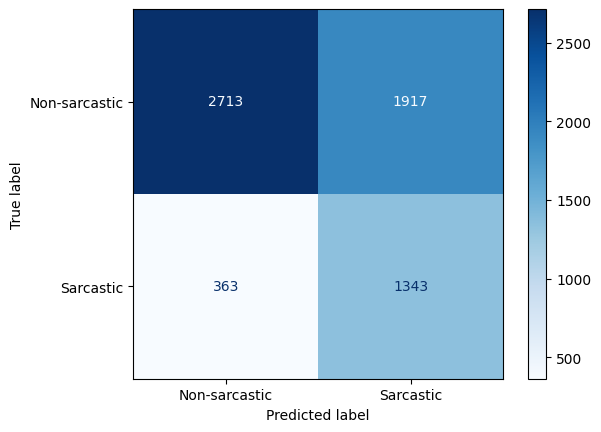

In [ ]:
print(classification_report(df2['labels'],svm_test_pred))
cm = confusion_matrix(df2['labels'], svm_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Logisitic Regression Display

              precision    recall  f1-score   support

           0       0.87      0.63      0.73      4630
           1       0.42      0.74      0.54      1706

    accuracy                           0.66      6336
   macro avg       0.64      0.68      0.63      6336
weighted avg       0.75      0.66      0.68      6336



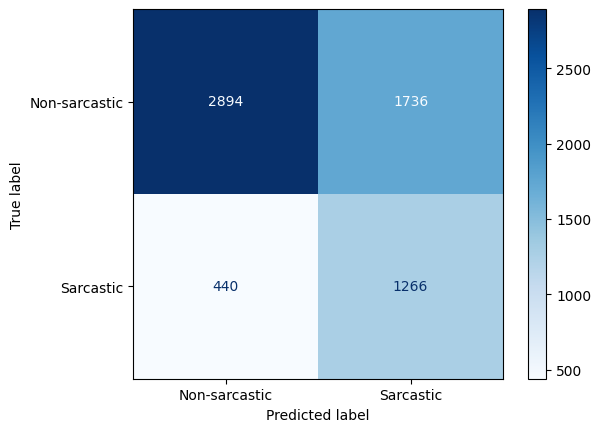

In [ ]:
print(classification_report(df2['labels'],lr_test_pred))
cm = confusion_matrix(df2['labels'], lr_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

KNN Display

              precision    recall  f1-score   support

           0       0.82      0.66      0.73      4630
           1       0.40      0.60      0.48      1706

    accuracy                           0.65      6336
   macro avg       0.61      0.63      0.60      6336
weighted avg       0.70      0.65      0.66      6336



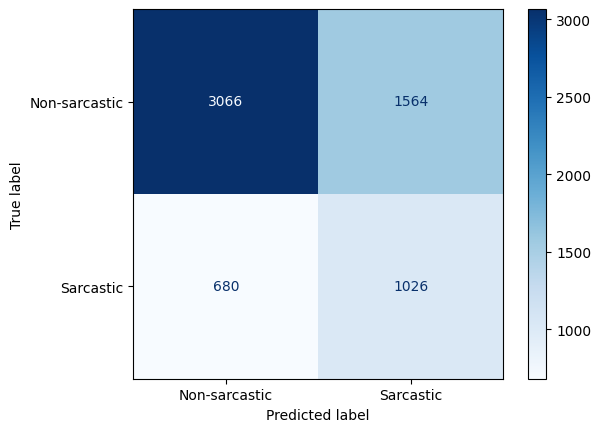

In [ ]:
print(classification_report(df2['labels'],knn_test_pred))
cm = confusion_matrix(df2['labels'], knn_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Random Forest Display

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4630
           1       0.47      0.50      0.48      1706

    accuracy                           0.71      6336
   macro avg       0.64      0.64      0.64      6336
weighted avg       0.72      0.71      0.72      6336



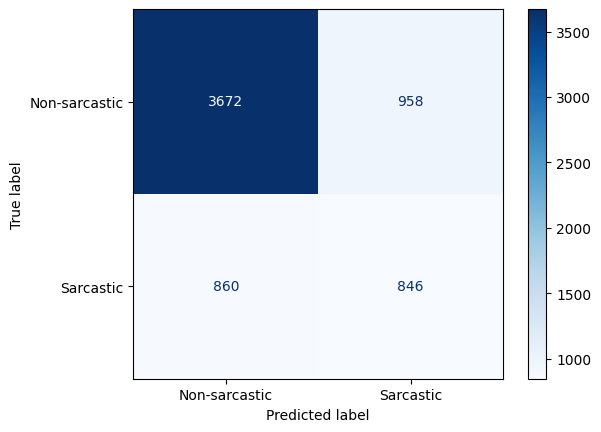

In [ ]:
print(classification_report(df2['labels'],rf_test_pred))
cm = confusion_matrix(df2['labels'], rf_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Decision Tree Display

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      4630
           1       0.39      0.48      0.43      1706

    accuracy                           0.66      6336
   macro avg       0.59      0.60      0.59      6336
weighted avg       0.68      0.66      0.67      6336



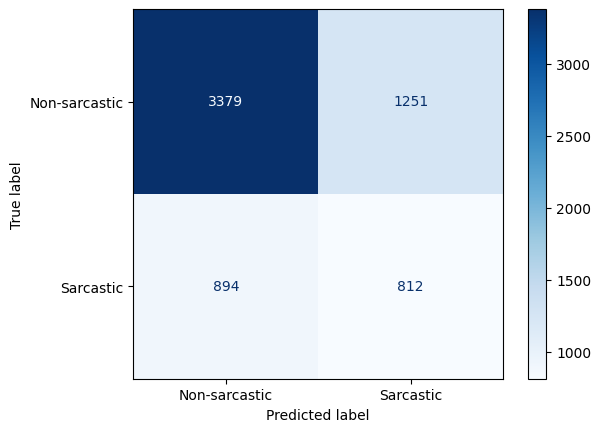

In [ ]:
print(classification_report(df2['labels'], dt_test_pred))
cm = confusion_matrix(df2['labels'], dt_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Ensemble Display

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      4630
           1       0.45      0.60      0.51      1706

    accuracy                           0.69      6336
   macro avg       0.64      0.66      0.64      6336
weighted avg       0.73      0.69      0.70      6336



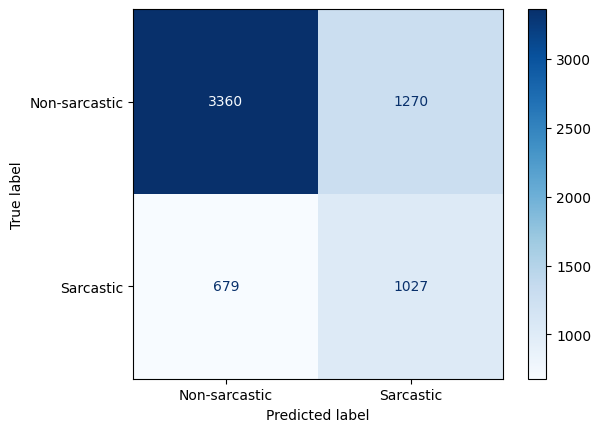

In [ ]:
print(classification_report(df2['labels'], ensemble_test_pred))
cm = confusion_matrix(df2['labels'], ensemble_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Bagging Display

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4630
           1       0.45      0.43      0.44      1706

    accuracy                           0.70      6336
   macro avg       0.62      0.62      0.62      6336
weighted avg       0.70      0.70      0.70      6336



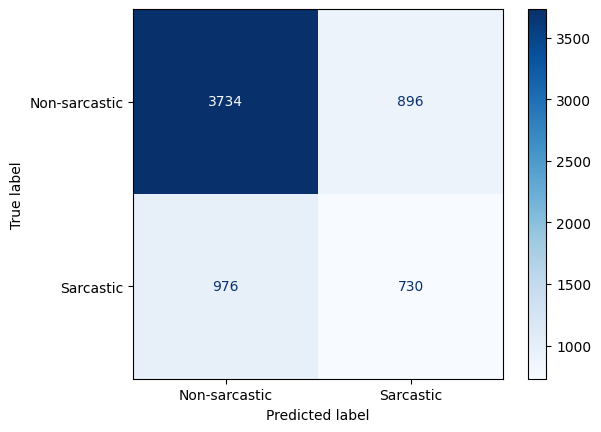

In [ ]:
print(classification_report(df2['labels'], bag_test_pred))
cm = confusion_matrix(df2['labels'], bag_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Gradient Boosting

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      4630
           1       0.43      0.71      0.53      1706

    accuracy                           0.67      6336
   macro avg       0.64      0.68      0.64      6336
weighted avg       0.74      0.67      0.68      6336



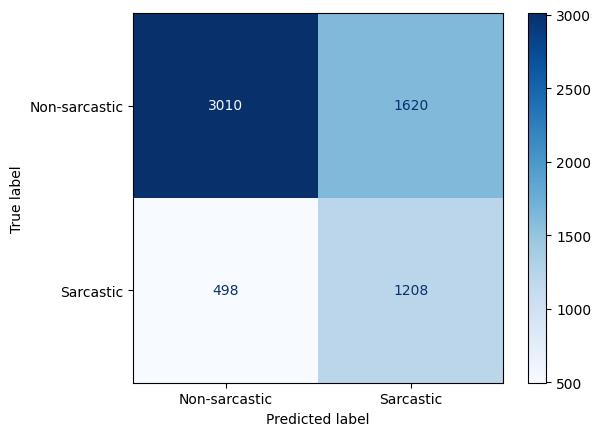

In [ ]:
print(classification_report(df2['labels'], gb_test_pred))
cm = confusion_matrix(df2['labels'], gb_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Stacking

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      4630
           1       0.50      0.33      0.40      1706

    accuracy                           0.73      6336
   macro avg       0.64      0.61      0.61      6336
weighted avg       0.71      0.73      0.71      6336



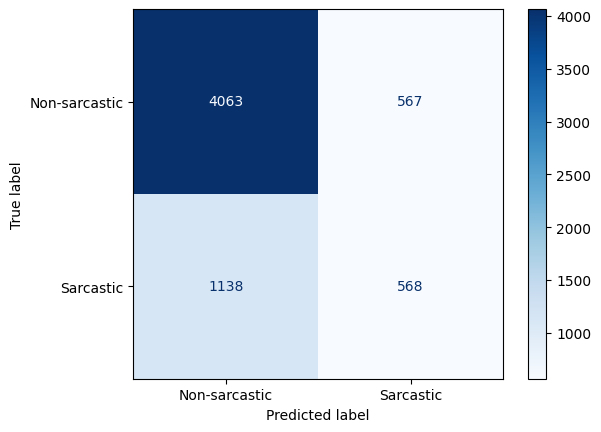

In [ ]:
print(classification_report(df2['labels'], stack_test_pred))
cm = confusion_matrix(df2['labels'], stack_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-sarcastic","Sarcastic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()